In [1]:

# Import the necessary bibliotheks



from IPython.display import display, clear_output
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

import importlib
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

from keras.callbacks import LearningRateScheduler

from sklearn.metrics import precision_score, recall_score, f1_score

from keras.callbacks import EarlyStopping

from keras.optimizers import Adam



11490434/11490434 [==============================] - 1s 0us/step
x_train: (60000, 28, 28)
y_train: (60000,)
x_test: (10000, 28, 28)
y_test: (10000,)

 Plot of the first 25 samples in the MNIST training set


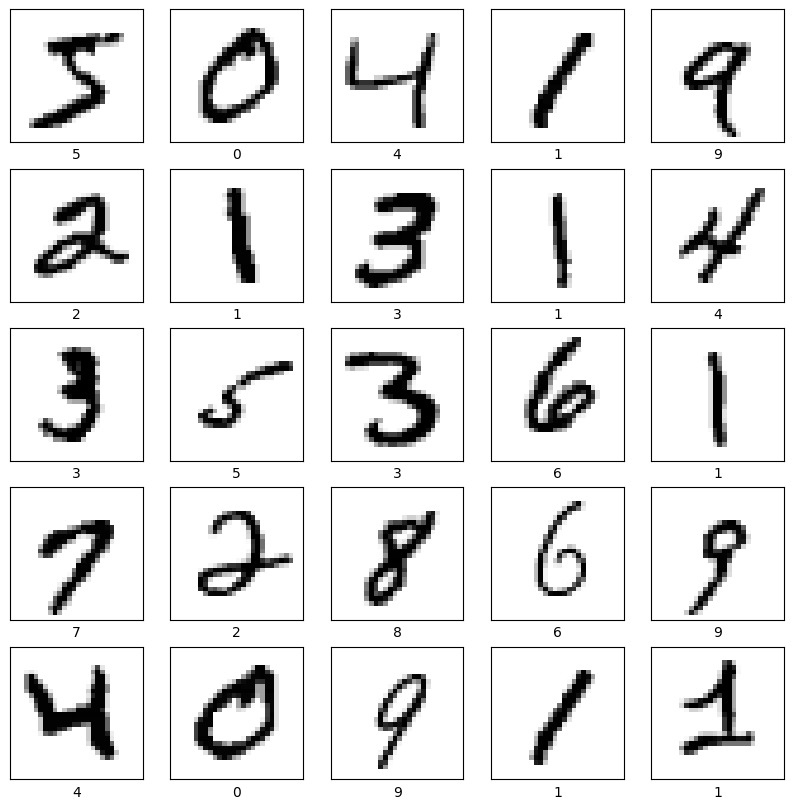

In [2]:
# define data preparation

# Loading the MNIST dataset in one line
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)


samples_per_class = 500
unique_labels = np.unique(y_train)
selected_indices = []

for label in unique_labels:
    indices = np.where(y_train == label)[0][:samples_per_class]
    selected_indices.extend(indices)

x_train_subset = x_train[selected_indices]
y_train_subset = y_train[selected_indices]


datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip = False,
    vertical_flip = False)





# Plotting data samples
print('\n Plot of the first 25 samples in the MNIST training set')
numbers_to_display = 25
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(10,10))
for i in range(numbers_to_display):
    plt.subplot(num_cells, num_cells, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

In [3]:
# Normalizing the data and reshape it
x_train_normalized = x_train_subset/255
x_test_normalized = x_test/255

x_train= x_train_normalized.reshape(-1, 28, 28, 1)
x_test = x_test_normalized.reshape(-1, 28, 28, 1)


In [4]:


marvin = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.AveragePooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])




In [5]:
#Summery of the model

marvin.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 average_pooling2d (Average  (None, 5, 5, 64)          0         
 Pooling2D)                                                      
                                                                 
 dropout (Dropout)           (None, 5, 5, 64)          0         
                                                                 
 flatten (Flatten)           (None, 1600)              0

In [6]:

# Define your loss
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

print(-tf.math.log(1/10))

sampleID = 20
loss_fn(y_train[:1], marvin(x_train[sampleID-1:sampleID]).numpy()).numpy()


tf.Tensor(2.3025851, shape=(), dtype=float32)


2.322497

In [7]:
# Compiling the model with using the optimizer Adam the definde loss and the metric accuracy
marvin.compile(optimizer='adam',
              loss=loss_fn ,
              metrics=['accuracy'])


In [8]:
#definde the tensorboard as a metric, the checkpoint for saveing the best model and the early stopping callback
import datetime
import os
%load_ext tensorboard


logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

checkpoint_path = "model_checkpoint_best_acc.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    save_weights_only=False,
    verbose=1
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [11]:
#the Training and the metrics precision, recall and F1 score
batch_size = 64
epochs = 30


#def linear_decay(epoch, lr):
#    initial_lr = 0.001
#    decay_rate = 0.01
#    new_lr = lr - decay_rate * epoch
#    lr =  max(new_lr, 0.001)
#    return lr
#lr_scheduler = LearningRateScheduler(linear_decay)


marvin.fit(datagen.flow(x_train, y_train_subset, batch_size=batch_size),
                    steps_per_epoch=len(x_train) // batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks=[tensorboard_callback, checkpoint_callback, early_stopping])



true_labels = to_categorical(y_test)
predictions = marvin.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(true_labels, axis=1)

precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')



Epoch 1/30
77/78 [============================>.] - ETA: 0s - loss: 0.1551 - accuracy: 0.9557
Epoch 1: val_accuracy did not improve from 0.97890
78/78 [==============================] - 3s 33ms/step - loss: 0.1550 - accuracy: 0.9558 - val_loss: 0.0780 - val_accuracy: 0.9756
Epoch 2/30
77/78 [============================>.] - ETA: 0s - loss: 0.1639 - accuracy: 0.9456
Epoch 2: val_accuracy did not improve from 0.97890
78/78 [==============================] - 4s 48ms/step - loss: 0.1648 - accuracy: 0.9453 - val_loss: 0.0725 - val_accuracy: 0.9766
Epoch 3/30
76/78 [============================>.] - ETA: 0s - loss: 0.1748 - accuracy: 0.9480
Epoch 3: val_accuracy did not improve from 0.97890
78/78 [==============================] - 2s 31ms/step - loss: 0.1739 - accuracy: 0.9487 - val_loss: 0.1762 - val_accuracy: 0.9451
Epoch 4/30
77/78 [============================>.] - ETA: 0s - loss: 0.1547 - accuracy: 0.9536
Epoch 4: val_accuracy did not improve from 0.97890
78/78 [=======================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 9/30
78/78 [==============================] - ETA: 0s - loss: 0.1282 - accuracy: 0.9609
Epoch 9: val_accuracy did not improve from 0.98070
78/78 [==============================] - 3s 32ms/step - loss: 0.1282 - accuracy: 0.9609 - val_loss: 0.0762 - val_accuracy: 0.9750
Epoch 10/30
78/78 [==============================] - ETA: 0s - loss: 0.1159 - accuracy: 0.9652
Epoch 10: val_accuracy improved from 0.98070 to 0.98150, saving model to model_checkpoint_best_acc.h5
78/78 [==============================] - 3s 32ms/step - loss: 0.1159 - accuracy: 0.9652 - val_loss: 0.0578 - val_accuracy: 0.9815
Epoch 11/30
77/78 [============================>.] - ETA: 0s - loss: 0.1248 - accuracy: 0.9643
Epoch 11: val_accuracy did not improve from 0.98150
313/313 [==============================] - 1s 2ms/step
Precision: 0.9808123231174833
Recall: 0.9807
F1-Score: 0.9806961287114937


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# This line would start up tensorboard for you
%tensorboard --logdir logs

In [12]:

# posibility to save the current model
model_name = 'lastmodel'
marvin.save(model_name, save_format='h5')


print('Success! You saved Marvin as: ', model_name)


Success! You saved Marvin as:  lastmodel


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:

# load a saved marvin configuration you want to evaluate
model_name = 'lastmodel'
marvin_reloaded = tf.keras.models.load_model(model_name)

# Let Marvin predict on the test set, so we have some data to evaluate his performance.
predictions = marvin_reloaded.predict([x_test])

predictions = np.argmax(predictions, axis=1)
#pd.DataFrame(predictions)


313/313 [==============================] - 1s 3ms/step


<ipython-input-14-9baaff025309>:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(num_cells, num_cells, plot_index + 1)


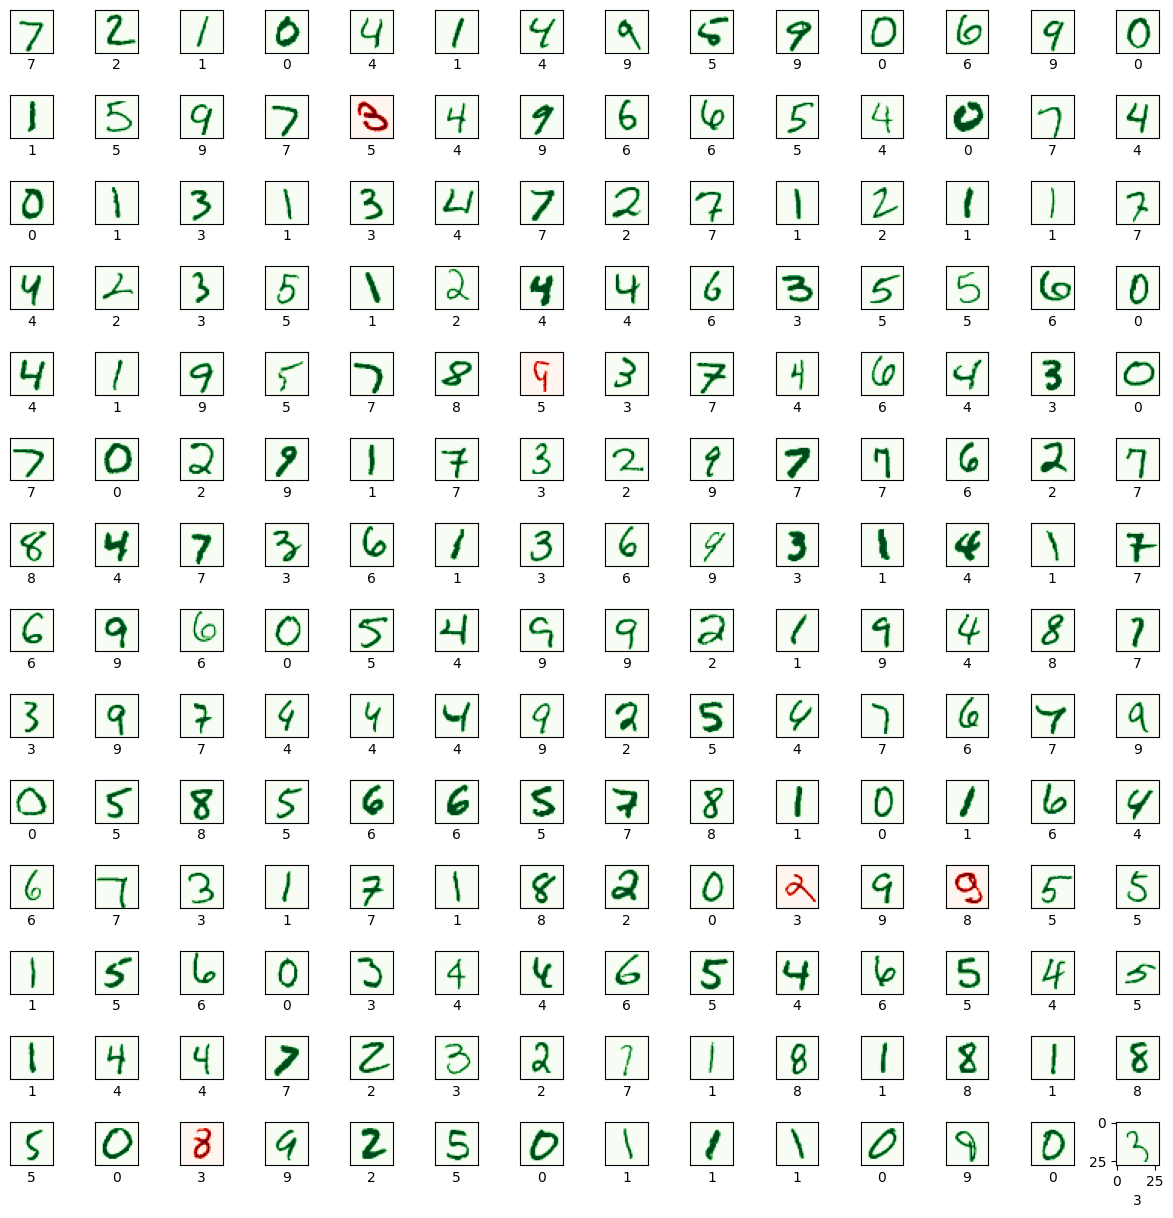

In [14]:

# Plot for the intuitive approach

numbers_to_display = 196
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(15, 15))

for plot_index in range(numbers_to_display):
    predicted_label = predictions[plot_index]
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    color_map = 'Greens' if predicted_label == y_test[plot_index] else 'Reds'
    plt.subplot(num_cells, num_cells, plot_index + 1)
    plt.imshow(x_test_normalized[plot_index].reshape((28, 28)), cmap=color_map)
    plt.xlabel(predicted_label)

plt.subplots_adjust(hspace=1, wspace=0.5)
plt.show()

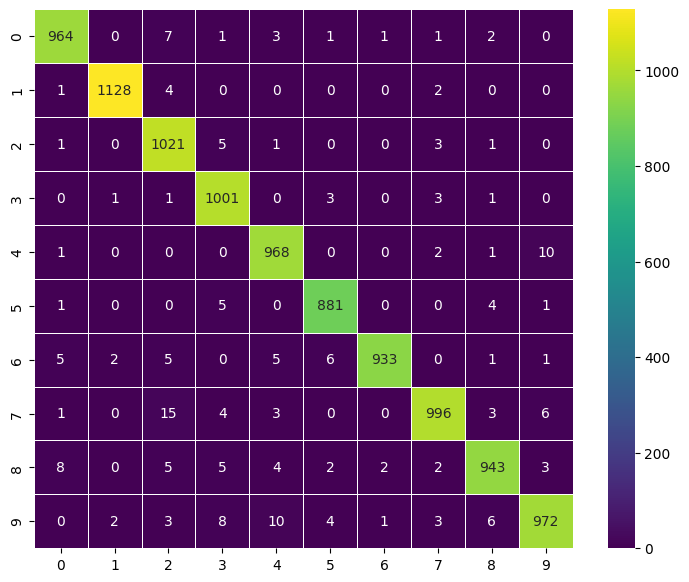

In [15]:
#plotting the confusion matrix
confusion_matrix = tf.math.confusion_matrix(y_test, predictions)

f, ax = plt.subplots(figsize=(9, 7))
sn.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.7,
    fmt="d",
    square=True,
    ax=ax,
    cmap="viridis",
)
plt.show()